In [1]:
import mibitrans as mbt
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfcx
from scipy.special import erfc

## Effects of the untruncated Domenico solution

#### Introduction

The analytical equation used in BIOSCREEN uses Domenico (1987) analytical solution for multidimensional transport of a contaminant species, but with the addition of source depletation and source superposition (to allow for more source zones). However, this solution is a truncation of the full analytical equation, which contains an additional term with a product of a exp and erfc function. This additional term does not require a lot of additional computing time in the context of mibitrans, and is therefore included in the 'Domenico' solution of this package. See equations below.

(equation_in_bioscreen; truncated)

(equation_in_mibitrans; untruncated)

This notebook gives an overview of the differences between the truncated and untruncated Domenico solution, and briefly discusses the implementation in mibitrans.

Note that exact analytical models (like Wexler (1992), which is the basis for the Karanovic solution, as implemented in BIOSCREEN-AT) still give more accurate results than the Domenico solution, regardless of truncation (West et al., 2007).


#### Over- and underflow of the additional term

In mibitrans, 64-bit float numpy arrays are used for the calculations and as a consequence, which can hold values between approximately $10^{-300}$ and $10^{+300}$. While these are generally beyond any reasonable order of magnitude, certain parameter combinations can cause an underflow (value < $10^{-300}$ and therefore set to 0), or overflow (value > $10^{+300}$ and therefore set to infinity) to occur. Especially at distances further from the source. However, this does necessarily mean that the additional term is negligibly small, as for $a \to \infty$, $\exp(a) \to \infty$ and $\text{erfc}(a) \to 0$. To combat this, the erfcx function is used, where $\text{erfcx}(a) = \exp(a^2) \cdot \text{erfc}(a)$. This transforms the additional term as: $\exp(b) \cdot \text{erfc}(a) = \exp(b - a^2) \cdot \text{erfcx}(b)$. Under any reasonable field condition, this expression of the additional will not over- or underflow. And is therefore implemented as such in mibitrans.

#### Visualization of the additional term

Consider the following parameters as example field conditions

In [92]:
hydro = mbt.HydrologicalParameters(
    velocity=0.1,
    porosity=0.3,
    alpha_x=1,
    alpha_y=0,
    alpha_z=0,
)

att = mbt.AttenuationParameters(
    retardation=1,
)

source = mbt.SourceParameters(
    source_zone_boundary=np.array([5,10,15]),
    source_zone_concentration=np.array([15,10,5]),
    total_mass="inf",
    depth=10,
)

model = mbt.ModelParameters(
    model_length=200,
    model_width=50,
    model_time=5*365,
    dx=1,
    dy=0.1,
    dt=5,
)

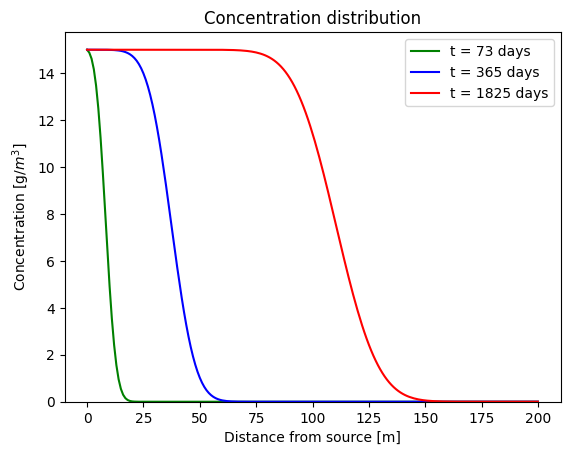

In [95]:
ndeg_obj = mbt.NoDecay(hydro,att, source, model)

ndeg_obj.centerline(time=73, color="green", label="t = 73 days")
ndeg_obj.centerline(time=365, color="blue", label="t = 365 days")
ndeg_obj.centerline(time=3*365, color="red", label="t = 10 days")
plt.title("Concentration distribution")
plt.legend()
plt.show()

In [88]:
365 * 3

1095

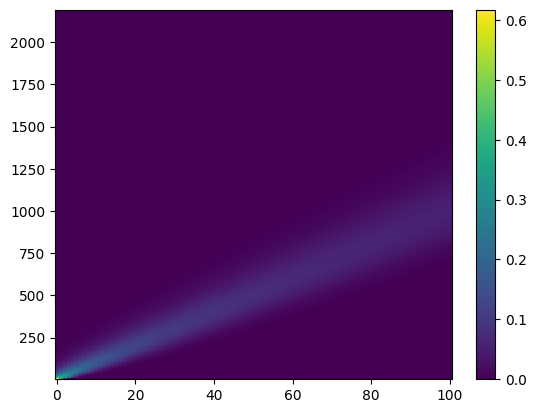

In [83]:
xxx = ndeg_obj.xxx
ttt = ndeg_obj.ttt
rv = ndeg_obj.rv
alpha_x = hydro.alpha_x
velocity = hydro.velocity


erfc_inner = (xxx + rv * ttt) / (2 * np.sqrt(alpha_x * rv * ttt))
term = np.exp(xxx / alpha_x - erfc_inner**2) * erfcx(erfc_inner)
plt.pcolormesh(xxx[None, None, :], ttt[:, None, None], term[:, 0, :])
plt.colorbar()
plt.show()


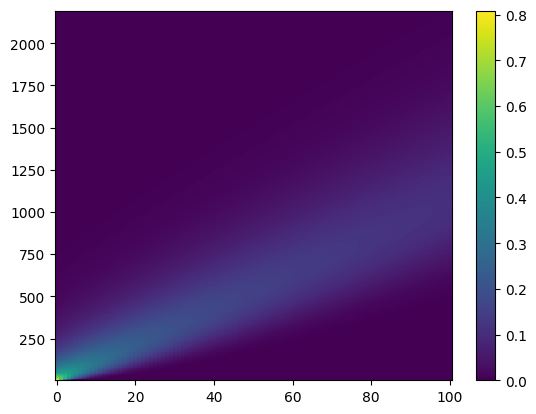

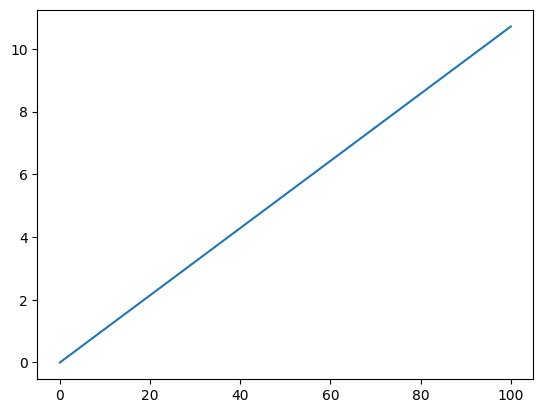

C:\Users\4662504\AppData\Local\Temp\ipykernel_34660\3969437810.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(xxx[None, None, :], ttt[:, None, None], np.log10(erfc_term[:, 0, :]))


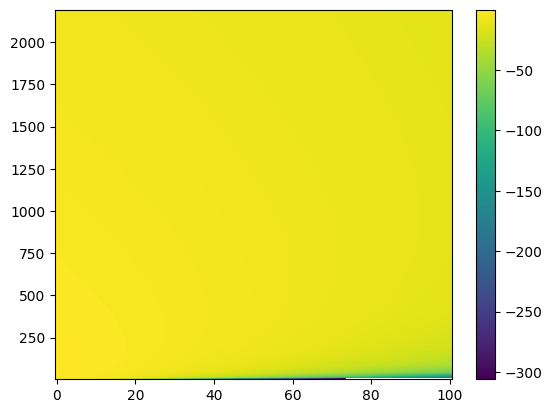

In [67]:
exp_term = np.exp(xxx * rv / (alpha_x * rv))
erfc_term = erfc(erfc_inner)
term = exp_term * erfc_term
plt.pcolormesh(xxx[None, None, :], ttt[:, None, None], term[:, 0, :])
plt.colorbar()
plt.show()

plt.plot(xxx[0, 0, :], np.log10(exp_term[0, 0, :]))
plt.show()

plt.pcolormesh(xxx[None, None, :], ttt[:, None, None], np.log10(erfc_term[:, 0, :]))
plt.colorbar()
plt.show()

In [4]:
ft = 3.281

In [5]:
hydro = mbt.HydrologicalParameters(
    velocity=113.8/ft/365,   # Groundwater flow velocity, in [m/day]
    porosity=0.25,           # Effective soil porosity [-]
    alpha_x=13.3/ft,         # Longitudinal dispersivity, in [m]
    alpha_y=1.3/ft,          # Transverse horizontal dispersivity, in [m]
    alpha_z=0                # Transverse vertical dispersivity, in [m]
)

att = mbt.AttenuationParameters(
    # Soil bulk density in [g/m^3]
    bulk_density=1.7,
    # Partition coefficient of the transported contaminant to soil organic matter, in [m^3/g]
    partition_coefficient=38,
    # Fraction of organic material in the soil [-]
    fraction_organic_carbon=5.7e-5,
    # Molecular diffusion, in [m2/day]
    diffusion=0,
    # Contaminant half life, in [days]
    half_life=54.75,
    # Electron acceptor concentrations input as dictionary
    electron_acceptors={
        # Difference between background oxygen and current oxygen concentration in groundwater, in [g/m^3]
        "delta_oxygen":1.65,
        # Difference between background nitrate and current nitrate concentration in groundwater, in [g/m^3]
        "delta_nitrate":0.7,
        # Current ferrous iron concentration in groundwater, in [g/m^3]
        "ferrous_iron":16.6,
        # Difference between background sulfate and current sulfate concentration in groundwater, in [g/m^3]
        "delta_sulfate":22.4,
        # Current methane concentration in groundwater, in [g/m^3]
        "methane":6.6,
    }
)

# Alternatively, specify a source mass to allow for source decay
source = mbt.SourceParameters(
    source_zone_boundary=np.array([7/ft, 37/ft, 65/ft]),
    source_zone_concentration=np.array([13.68, 2.508, 0.057]),
    depth=10/ft,
    total_mass=2000000
)

model = mbt.ModelParameters(
    # Model extent in the longitudinal (x) direction in [m].
    model_length = 320/ft,
    # Model extent in the transverse horizontal (y) direction in [m].
    model_width = 100/ft,
    # Model duration in [days].
    model_time = 6 * 365,
    # Model grid discretization step size in the longitudinal (x) direction, in [m].
    dx = 1/ft,
    # Model grid discretization step size in the transverse horizontal (y) direction, in [m].
    dy = 1/ft,
    # Model time discretization step size, in [days]
    dt = 365 / 5
)